# Multivariate Linear Models

In [1]:
import  warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pymc3 as pm
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
%matplotlib inline

In [3]:
sns.set()

## Spurious Association

### 5.1

In [4]:
d = pd.read_csv('Data/WaffleDivorce.csv', sep=';')
d["MedianAgeMarriage_s"] = (d["MedianAgeMarriage"] - d["MedianAgeMarriage"].mean())/d["MedianAgeMarriage"].std()

In [5]:
with pm.Model() as m5_1:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    bA = pm.Normal("bA", mu=0, sd=1)
    a = pm.Normal("a", mu=10, sd=10)
    mu = pm.Deterministic("mu", a + bA * d["MedianAgeMarriage_s"])
    Divorce = pm.Normal("Divorce", mu=mu, sd=sigma, observed=d["Divorce"])
    trace_5_1 = pm.sample(int(1e4), tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bA, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:26<00:00, 832.04draws/s] 


### 5.2

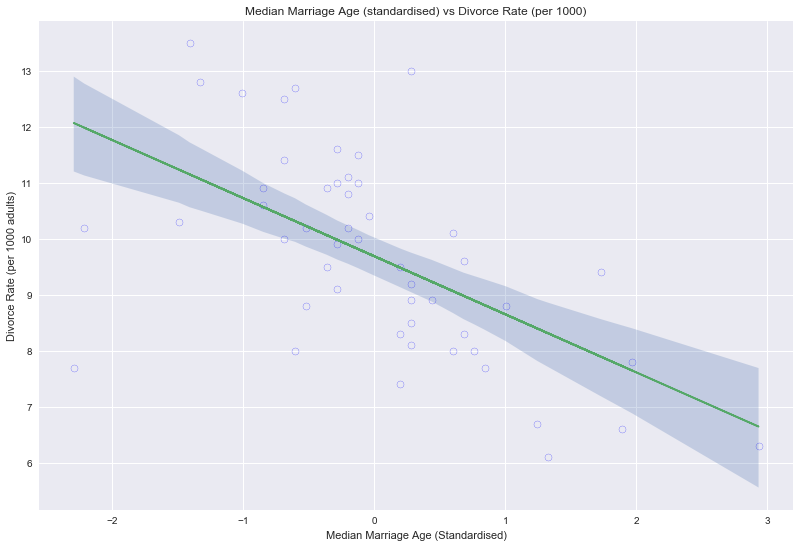

In [6]:
mu_mean = trace_5_1["mu"]
mu_pi = pm.hpd(mu_mean, alpha=0.11)

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
ax.plot(d["MedianAgeMarriage_s"], d["Divorce"], "o", mew=0.2, mec="b", mfc="None")
ax.plot(d["MedianAgeMarriage_s"], mu_mean.mean(0))

idx = np.argsort(d["MedianAgeMarriage_s"])
ax.fill_between(d["MedianAgeMarriage_s"][idx], mu_pi[:,0][idx], mu_pi[:,1][idx], alpha=0.25)

ax.set_title("Median Marriage Age (standardised) vs Divorce Rate (per 1000)")
ax.set_xlabel("Median Marriage Age (Standardised)")
ax.set_ylabel("Divorce Rate (per 1000 adults)");

### 5.3

In [7]:
d["Marriage_s"] = (d["Marriage"] - d["Marriage"].mean())/d["Marriage"].std()

In [8]:
with pm.Model() as m5_2:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    bA = pm.Normal("bA", mu=0, sd=1)
    a = pm.Normal("a", mu=10, sd=10)
    mu = pm.Deterministic("mu", a + bA * d["Marriage_s"])
    Divorce = pm.Normal("Divorce", mu=mu, sd=sigma, observed=d["Divorce"])
    trace_5_2 = pm.sample(int(1e4), tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bA, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:17<00:00, 1290.10draws/s]


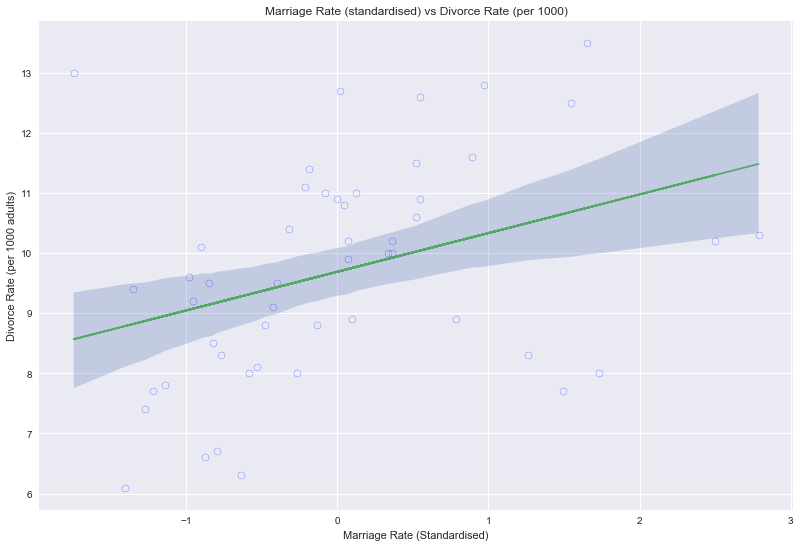

In [9]:
mu_mean = trace_5_2["mu"]
mu_pi = pm.hpd(mu_mean, alpha=0.11)

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
ax.plot(d["Marriage_s"], d["Divorce"], "o", mew=0.2, mec="b", mfc="None")
ax.plot(d["Marriage_s"], mu_mean.mean(0))

idx = np.argsort(d["Marriage_s"])
ax.fill_between(d["Marriage_s"][idx], mu_pi[:,0][idx], mu_pi[:,1][idx], alpha=0.25)

ax.set_title("Marriage Rate (standardised) vs Divorce Rate (per 1000)")
ax.set_xlabel("Marriage Rate (Standardised)")
ax.set_ylabel("Divorce Rate (per 1000 adults)");

### 5.4

In [10]:
with pm.Model() as m5_3:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    bA = pm.Normal("bA", mu=0, sd=1)    
    bR = pm.Normal("bR", mu=0, sd=1)    
    a = pm.Normal("a", mu=10, sd=10)
    mu = pm.Deterministic("mu", a + bR * d["Marriage_s"]) + bA * d["MedianAgeMarriage_s"]
    Divorce = pm.Normal("Divorce", mu=mu, sd=sigma, observed=d["Divorce"])
    trace_5_3 = pm.sample(int(1e4), tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bR, bA, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:28<00:00, 776.12draws/s]


In [11]:
pm.summary(trace_5_3, varnames=["a", "bR", "bA", "sigma"], alpha=0.11)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,9.686131,0.218414,0.001520,9.337716,10.036663,17279.579241,0.999957
bR,-0.121298,0.296206,0.002325,-0.600695,0.347163,13730.687793,0.999973
bA,-1.121037,0.295793,0.002291,-1.600797,-0.653715,13741.065409,0.999958
sigma,1.527420,0.161983,0.001210,1.269649,1.770311,14305.603671,0.999950


### 5.5

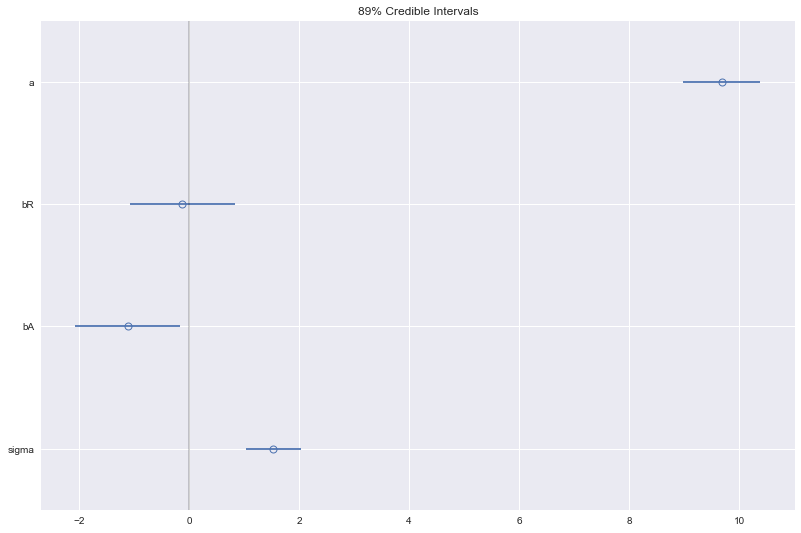

In [12]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
data = pm.summary(trace_5_3, varnames=["a", "bR", "bA", "sigma"], alpha=0.11)
ax.errorbar(data["mean"], data.index, fmt="o", xerr=data["hpd_94.5"] - data["hpd_5.5"], 
            mew=1, mfc="None")
ax.vlines(0, ymin=-1, ymax=4, alpha=0.2);
ax.set_ylim(-0.5, 3.5)
ax.invert_yaxis()
ax.set_title("89% Credible Intervals");

### 5.6

In [13]:
with pm.Model() as m5_4:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    b = pm.Normal("b", mu=0, sd=1)    
    a = pm.Normal("a", mu=0, sd=10)
    mu = pm.Deterministic("mu", a + b * d["MedianAgeMarriage_s"])
    Marriage_s = pm.Normal("Marriage_s", mu=mu, sd=sigma, observed=d["Marriage_s"])
    trace_5_4 = pm.sample(int(1e4), tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, b, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:18<00:00, 1203.67draws/s]


### 5.7

In [14]:
mu = trace_5_4["mu"].mean(0)
m_resid = d["Marriage_s"] - mu

### 5.8

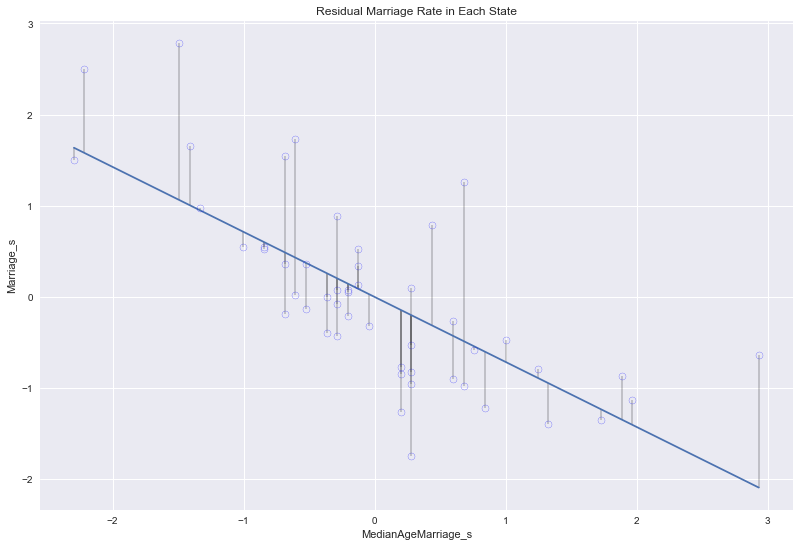

In [15]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
idx = np.argsort(d["MedianAgeMarriage_s"])
ax.plot(d["MedianAgeMarriage_s"][idx], mu[idx])
ax.vlines(d["MedianAgeMarriage_s"], mu, mu + m_resid, alpha=0.2)
ax.plot(d["MedianAgeMarriage_s"], mu + m_resid, "o", mew=0.2, mec="b", mfc="None")
ax.set_title("Residual Marriage Rate in Each State")
ax.set_xlabel("MedianAgeMarriage_s")
ax.set_ylabel("Marriage_s");

### 5.9

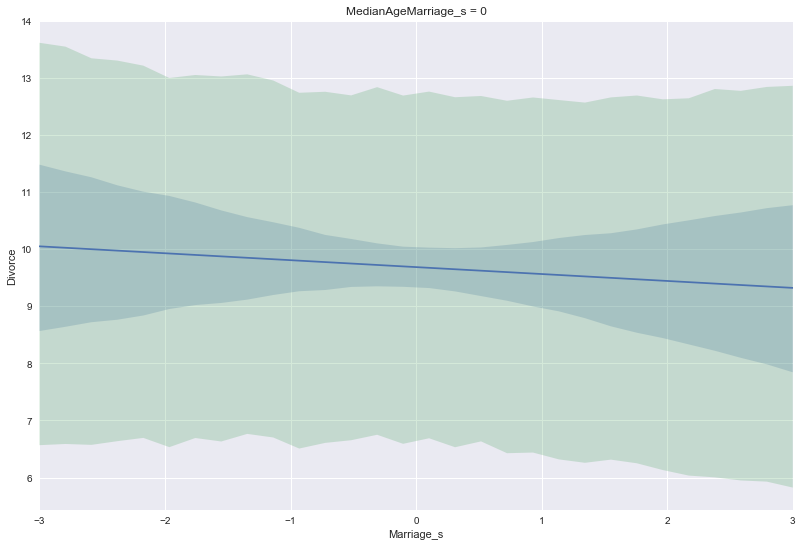

In [16]:
A_avg = d["MedianAgeMarriage_s"].mean()
R_seq = np.linspace(-3, 3, 30)

mu = trace_5_3["a"].reshape(-1, 1) +\
     (trace_5_3["bA"] * A_avg).reshape(-1, 1) +\
     (trace_5_3["bR"].reshape(-1, 1) * R_seq)

sigma = (trace_5_3["sigma"]
         .repeat(30)
         .reshape(-1, 30))

R_sim = stats.norm.rvs(loc=mu, scale=sigma)
mu_mean = mu.mean(axis=0)
mu_pi = pm.hpd(mu, alpha=.11)
R_pi = pm.hpd(R_sim)

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)

ax.plot(R_seq, mu_mean)
ax.fill_between(R_seq, mu_pi[:,0], mu_pi[:,1], alpha=0.25)
ax.fill_between(R_seq, R_pi[:,0], R_pi[:,1], alpha=0.25)
ax.set_title("MedianAgeMarriage_s = 0")
ax.set_xlabel("Marriage_s")
ax.set_ylabel("Divorce")
ax.set_xlim(-3, 3);

### 5.10

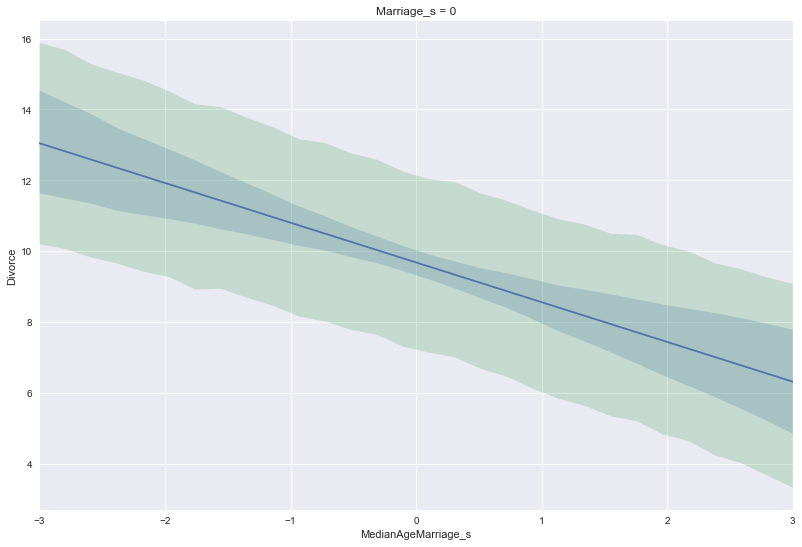

In [17]:
A_seq = np.linspace(-3, 3, 30)
R_avg = d["Marriage_s"].mean()

mu = trace_5_3["a"].reshape(-1, 1) +\
     (trace_5_3["bA"].reshape(-1, 1) * A_seq) +\
     (trace_5_3["bR"] * R_avg).reshape(-1, 1)

sigma = (trace_5_3["sigma"]
         .repeat(30)
         .reshape(-1, 30))

A_sim = stats.norm.rvs(loc=mu, scale=sigma)
mu_mean = mu.mean(axis=0)
mu_pi = pm.hpd(mu, alpha=.11)
A_pi = pm.hpd(A_sim, alpha=.11)

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)

ax.plot(A_seq, mu_mean)
ax.fill_between(A_seq, mu_pi[:,0], mu_pi[:,1], alpha=0.25)
ax.fill_between(A_seq, A_pi[:,0], A_pi[:,1], alpha=0.25)
ax.set_title("Marriage_s = 0")
ax.set_xlabel("MedianAgeMarriage_s")
ax.set_ylabel("Divorce")
ax.set_xlim(-3, 3);

### 5.11

In [18]:
mu = trace_5_3["mu"]

mu_mean = mu.mean(0).reshape(-1, 1)
mu_pi = pm.hpd(mu, alpha=.11)

divorce_sim = pm.sample_ppc(trace_5_3, samples=int(1e4), model=m5_3)['Divorce']
divorce_mean = divorce_sim.mean(0).reshape(-1, 1)
divorce_pi = pm.hpd(divorce_sim, alpha=.11)

100%|██████████| 10000/10000 [00:11<00:00, 896.39it/s]


### 5.12 - 5.13

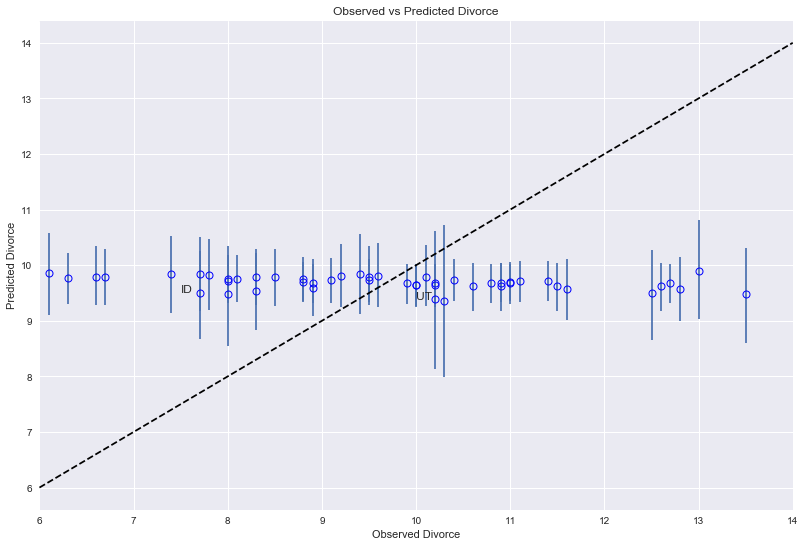

In [19]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)

ax.errorbar(x=d["Divorce"], y=mu_mean, fmt="o", yerr=np.abs(mu_mean - mu_pi).T,
           mew=1.0, mec="b", mfc="None");
ax.plot([6, 14], [6, 14], "k--")
ax.set_title("Observed vs Predicted Divorce")
ax.set_xlabel("Observed Divorce")
ax.set_ylabel("Predicted Divorce")
ax.set_xlim(6, 14)

ID = (d.loc[12]["Divorce"], mu_mean[12])
UT = (d.loc[43]["Divorce"], mu_mean[43])
ax.annotate("ID", ID, xytext=(ID[0]-0.2, ID[1]))
ax.annotate("UT", UT, xytext=(UT[0]-0.2, UT[1]));

### 5.14

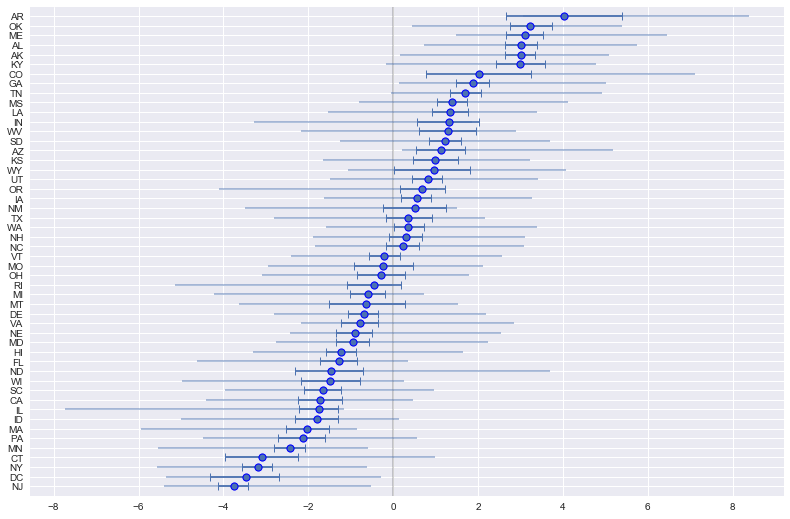

In [20]:
divorce_resid = d["Divorce"] - mu_mean.ravel()
o = np.argsort(divorce_resid)

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)

ax.vlines(0, -1, len(d), alpha=0.2)
ax.errorbar(divorce_resid[o], d.loc[o]["Loc"], xerr=np.abs(mu_mean-divorce_pi).T,
            fmt="o", mfc="C0", mew=1.0, mec="b", alpha=0.5, ecolor="C0")    
ax.errorbar(divorce_resid[o], d.loc[o]["Loc"], xerr=np.abs(mu_mean-mu_pi).T, 
            fmt="o", capsize=4, mfc="C0", mew=1.0, mec="b", ecolor="C0")
ax.set_ylim(-1, len(d));

### 5.15

In [21]:
N = 100
x_real = stats.norm.rvs(size=N)
x_spur = stats.norm.rvs(loc=x_real)
y = stats.norm.rvs(size=N, loc=x_real)
d = pd.DataFrame({"y": y,
                  "x_real": x_real,
                  "x_spur": x_spur})

## Masked Relationship

### 5.16

In [22]:
d = pd.read_csv('Data/milk.csv', sep=';')
d.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


### 5.17

In [23]:
with pm.Model() as m5_5:
    sigma = pm.Uniform("sigma", lower=0, upper=1)
    bn = pm.Normal("bn", mu=0, sd=1)    
    a = pm.Normal("a", mu=0, sd=100)
    mu = pm.Deterministic("mu", a + bn * d["neocortex.perc"])
    kcal_per_g = pm.Normal("kcal_per_g", mu=mu, sd=sigma, observed=d["kcal.per.g"])
    trace_5_5 = pm.sample(int(1e4), tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bn, sigma]
Sampling 2 chains:   0%|          | 0/22000 [00:00<?, ?draws/s]


RuntimeError: Chain 1 failed.

### 5.18

In [24]:
d["neocortex.perc"]

0     55.16
1       NaN
2       NaN
3       NaN
4       NaN
5     64.54
6     64.54
7     67.64
8       NaN
9     68.85
10    58.85
11    61.69
12    60.32
13      NaN
14      NaN
15    69.97
16      NaN
17    70.41
18      NaN
19    73.40
20      NaN
21    67.53
22      NaN
23    71.26
24    72.60
25      NaN
26    70.24
27    76.30
28    75.49
Name: neocortex.perc, dtype: float64

### 5.19

In [25]:
dcc = d.dropna()

### 5.20

In [26]:
with pm.Model() as m5_5:
    sigma = pm.Uniform("sigma", lower=0, upper=1)
    bn = pm.Normal("bn", mu=0, sd=1)    
    a = pm.Normal("a", mu=0, sd=100)
    mu = pm.Deterministic("mu", a + bn * dcc["neocortex.perc"])
    kcal_per_g = pm.Normal("kcal_per_g", mu=mu, sd=sigma, observed=dcc["kcal.per.g"])
    trace_5_5 = pm.sample(int(1e4), tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bn, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [01:20<00:00, 271.77draws/s]
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


### 5.21

In [27]:
pm.summary(trace_5_5, varnames=["a", "bn", "sigma"], alpha=0.11).round(3)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,0.355,0.564,0.006,-0.511,1.262,5636.094,1.0
bn,0.004,0.008,0.000,-0.009,0.017,5667.909,1.0
sigma,0.194,0.040,0.001,0.134,0.248,4358.425,1.0


### 5.22

In [28]:
trace_5_5["bn"].mean() * (76 - 55)

0.09397395922259122

### 5.23

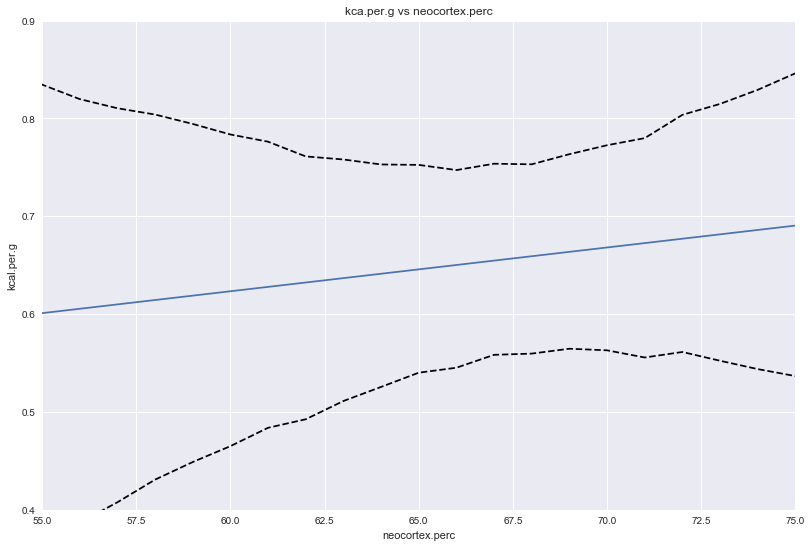

In [29]:
np_seq = np.arange(0, 100)

mu = trace_5_5["a"].reshape(-1, 1) +\
     (trace_5_5["bn"].reshape(-1, 1) * np_seq)

mu_mean = mu.mean(0)
mu_pi = pm.hpd(mu)

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)

ax.plot(np_seq, mu_mean)
ax.plot(np_seq, mu_pi[:, 0], "k--")
ax.plot(np_seq, mu_pi[:, 1], "k--")
ax.set_xlabel("neocortex.perc")
ax.set_ylabel("kcal.per.g")
ax.set_xlim(55, 75)
ax.set_title("kca.per.g vs neocortex.perc")
ax.set_ylim(0.4, 0.9);

### 5.24

In [30]:
dcc["log_mass"] = np.log(dcc["mass"])

### 5.25

In [31]:
with pm.Model() as m5_6:
    sigma = pm.Uniform("sigma", lower=0, upper=1)
    bm = pm.Normal("bm", mu=0, sd=1)    
    a = pm.Normal("a", mu=0, sd=100)
    mu = pm.Deterministic("mu", a + bm * dcc["log_mass"])
    kcal_per_g = pm.Normal("kcal_per_g", mu=mu, sd=sigma, observed=dcc["kcal.per.g"])
    trace_5_6 = pm.sample(int(1e4), tune=1000)
    
pm.summary(trace_5_6, varnames=["a", "bm", "sigma"], alpha=0.11)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bm, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:16<00:00, 1348.58draws/s]


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,0.705320,0.058335,0.000635,0.617246,0.800986,9291.098476,0.999950
bm,-0.031931,0.024363,0.000262,-0.069745,0.006905,9685.037924,1.000092
sigma,0.182923,0.037950,0.000344,0.127197,0.238377,9963.738981,1.000051


### 5.26

In [32]:
with pm.Model() as m5_7:
    sigma = pm.Uniform("sigma", lower=0, upper=1)
    bm = pm.Normal("bm", mu=0, sd=1)    
    bn = pm.Normal("bn", mu=0, sd=1)    
    a = pm.Normal("a", mu=0, sd=100)
    mu = pm.Deterministic("mu", a + bm*dcc["log_mass"] + bn*dcc["neocortex.perc"])
    kcal_per_g = pm.Normal("kcal_per_g", mu=mu, sd=sigma, observed=dcc["kcal.per.g"])
    trace_5_7 = pm.sample(int(1e4), tune=1000)

pm.summary(trace_5_7, varnames=["a", "bm", "bn", "sigma"], alpha=0.11)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bn, bm, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [02:23<00:00, 153.62draws/s]
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,-1.076502,0.595532,0.009560,-2.005269,-0.130098,4509.076862,1.000002
bm,-0.096301,0.028423,0.000404,-0.141007,-0.051864,5377.502476,0.999969
bn,0.027794,0.009264,0.000150,0.012998,0.042226,4450.233387,1.000007
sigma,0.139641,0.030664,0.000550,0.095428,0.185352,3375.356149,0.999972


### 5.27

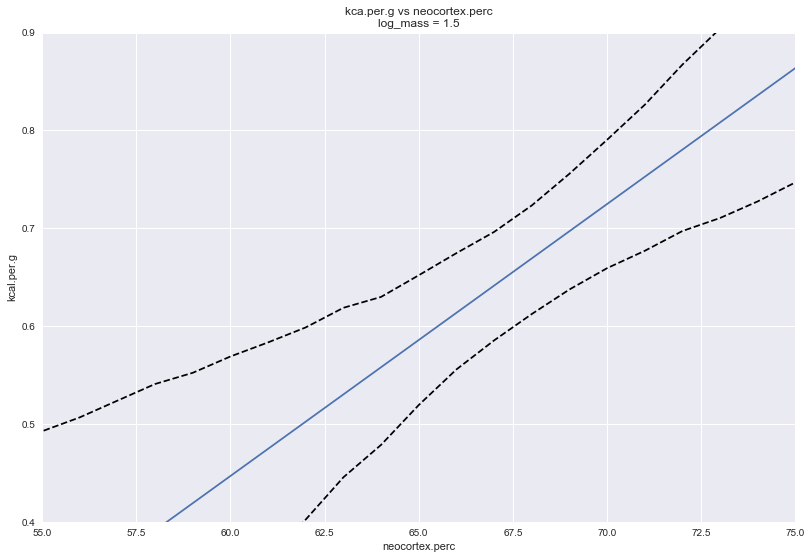

In [33]:
mean_log_mass = dcc["log_mass"].mean()
np_seq = np.arange(0, 100)

mu = trace_5_7["a"].reshape(-1, 1) +\
     (trace_5_7["bm"] * mean_log_mass).reshape(-1, 1) +\
     (trace_5_7["bn"].reshape(-1, 1) * np_seq)

mu_mean = mu.mean(axis=0)
mu_pi = pm.hpd(mu, alpha=.11)

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)

ax.plot(np_seq, mu_mean)
ax.plot(np_seq, mu_pi[:, 0], "k--")
ax.plot(np_seq, mu_pi[:, 1], "k--")
ax.set_xlabel("neocortex.perc")
ax.set_ylabel("kcal.per.g")
ax.set_xlim(55, 75)
ax.set_title("kca.per.g vs neocortex.perc\nlog_mass = 1.5")
ax.set_ylim(0.4, 0.9);

### 5.28

In [34]:
N = 100
rho = 0.7
x_pos = stats.norm.rvs(size=N)
x_neg = stats.norm.rvs(loc=rho*x_pos, scale=np.sqrt(1-rho**2))
y = stats.norm.rvs(loc=x_pos-x_neg)
d = pd.DataFrame({"y": y,
                  "x_pos": x_pos,
                  "x_neg": x_neg})

## When adding variables hurts

### 5.29

In [35]:
N = 100
height = stats.norm.rvs(10, 2, N)
leg_prop = stats.uniform.rvs(0.4, 0.5, N)
leg_left = leg_prop*height + stats.norm.rvs(0, 0.02, N)
leg_right = leg_prop*height + stats.norm.rvs(0, 0.02, N)
d = pd.DataFrame({"height": height,
                  "leg_left": leg_left,
                  "leg_right": leg_right})

### 5.30

In [36]:
with pm.Model() as m5_8:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    br = pm.Normal("br", mu=2, sd=10)
    bl = pm.Normal("bl", mu=2, sd=10)
    a = pm.Normal("a", mu=10, sd=100)
    mu = pm.Deterministic("mu", a + bl*d["leg_left"] + br*d["leg_right"])
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d["height"])
    trace_5_8 = pm.sample(int(1e4), tune=1000)

pm.summary(trace_5_8, varnames=["a", "bl", "br", "sigma"], alpha=0.11)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bl, br, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [23:53<00:00, 15.35draws/s]  
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,5.324764,0.573328,0.004674,4.404328,6.240478,11417.371915,0.999992
bl,-8.363122,4.836438,0.055521,-16.081878,-0.687317,5782.986294,1.000124
br,9.094895,4.840934,0.055636,1.382345,16.758776,5775.176105,1.000126
sigma,1.578589,0.117233,0.001328,1.394930,1.765088,10095.688539,1.000110


### 5.31

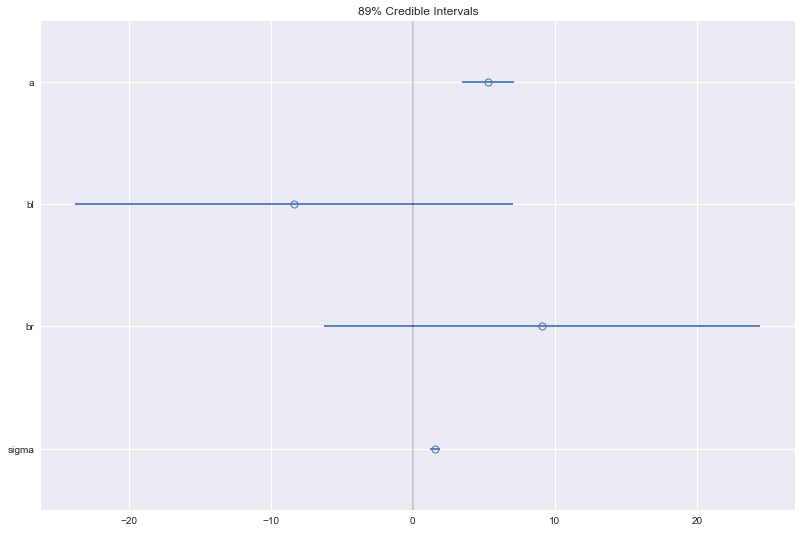

In [37]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
data = pm.summary(trace_5_8, varnames=["a", "bl", "br", "sigma"], alpha=0.11)
ax.errorbar(data["mean"], data.index, fmt="o", xerr=data["hpd_94.5"] - data["hpd_5.5"], 
            mew=1, mfc="None")
ax.vlines(0, ymin=-1, ymax=4, alpha=0.2);
ax.set_ylim(-0.5, 3.5)
ax.invert_yaxis()
ax.set_title("89% Credible Intervals");

### 5.32

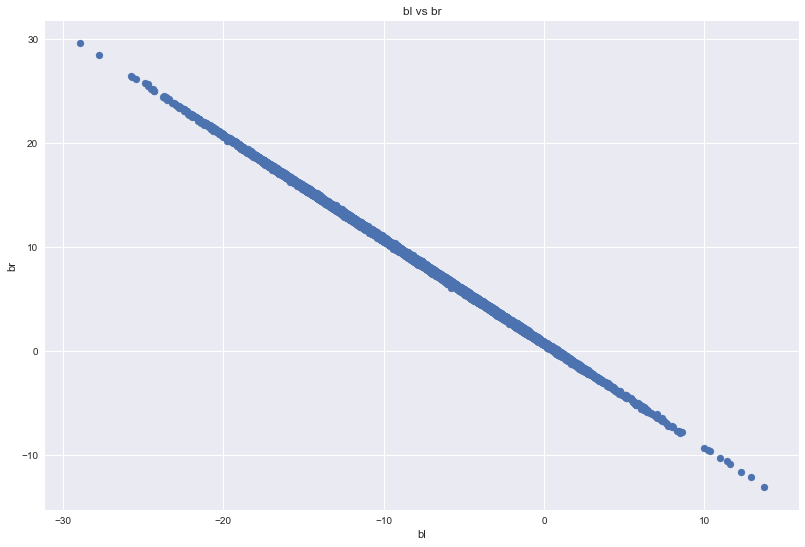

In [38]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
ax.scatter(trace_5_8["bl"], trace_5_8["br"])
ax.set_xlabel("bl")
ax.set_ylabel("br")
ax.set_title("bl vs br");

### 5.33

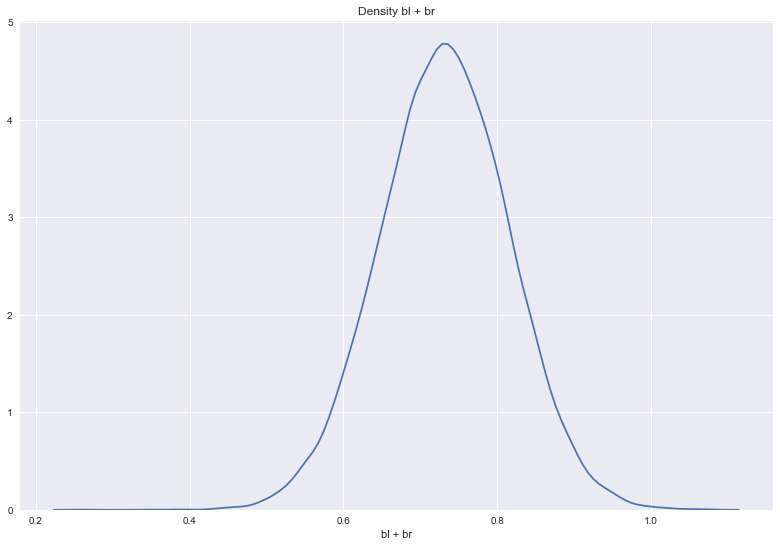

In [39]:
sum_blbr = trace_5_8["bl"] + trace_5_8["br"]

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
sns.kdeplot(sum_blbr, ax=ax)
ax.set_title("Density bl + br")
ax.set_xlabel("bl + br");

### 5.34

In [40]:
with pm.Model() as m5_9:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    bl = pm.Normal("bl", mu=2, sd=10)
    a = pm.Normal("a", mu=10, sd=100)
    mu = pm.Deterministic("mu", a + bl*d["leg_left"])
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d["height"])
    trace_5_9 = pm.sample(int(1e4), tune=1000)

pm.summary(trace_5_9, varnames=["a", "bl", "sigma"], alpha=0.11)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bl, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:23<00:00, 926.83draws/s]


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,5.414671,0.581589,0.006436,4.492516,6.343583,7344.908983,1.000079
bl,0.720961,0.084941,0.000941,0.586488,0.857067,7655.136305,1.000120
sigma,1.615387,0.117967,0.001288,1.427117,1.796550,9623.746882,1.000232


### 5.35

In [41]:
d = pd.read_csv('Data/milk.csv', sep=';')
d.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


### 5.36

In [42]:
# kcal.per.g regressed on perc.fat
with pm.Model() as m5_10:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    bf = pm.Normal("bf", mu=0, sd=1)
    a = pm.Normal("a", mu=0.6, sd=10)
    mu = pm.Deterministic("mu", a + bf*d["perc.fat"])
    kcal_per_g = pm.Normal("kcal_per_g", mu=mu, sd=sigma, observed=d["kcal.per.g"])
    trace_5_10 = pm.sample(int(1e4), tune=1000)

# kcal.per.g regressed on perc.lactose
with pm.Model() as m5_11:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    bl = pm.Normal("bl", mu=0, sd=1)
    a = pm.Normal("a", mu=0.6, sd=10)
    mu = pm.Deterministic("mu", a + bl*d["perc.lactose"])
    kcal_per_g = pm.Normal("kcal_per_g", mu=mu, sd=sigma, observed=d["kcal.per.g"])
    trace_5_11 = pm.sample(int(1e4), tune=1000)
    
print(pm.summary(trace_5_10, varnames=["a", "bf", "sigma"], alpha=0.11).round(3))
print(pm.summary(trace_5_11, varnames=["a", "bl", "sigma"], alpha=0.11).round(3))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bf, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:30<00:00, 731.01draws/s] 
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bl, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:30<00:00, 714.56draws/s]


        mean     sd  mc_error  hpd_5.5  hpd_94.5     n_eff  Rhat
a      0.301  0.039       0.0    0.239     0.364  6797.211   1.0
bf     0.010  0.001       0.0    0.008     0.012  6783.870   1.0
sigma  0.080  0.012       0.0    0.061     0.096  9589.817   1.0
        mean     sd  mc_error  hpd_5.5  hpd_94.5     n_eff  Rhat
a      1.167  0.047     0.001    1.089     1.239  7217.410   1.0
bl    -0.011  0.001     0.000   -0.012    -0.009  7226.964   1.0
sigma  0.067  0.010     0.000    0.052     0.082  8349.996   1.0


### 5.37

In [43]:
with pm.Model() as m5_12:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    bl = pm.Normal("bl", mu=0, sd=1)
    bf = pm.Normal("bf", mu=0, sd=1)
    a = pm.Normal("a", mu=0.6, sd=10)
    mu = pm.Deterministic("mu", a + bf*d["perc.fat"] + bl*d["perc.lactose"])
    kcal_per_g = pm.Normal("kcal_per_g", mu=mu, sd=sigma, observed=d["kcal.per.g"])
    trace_5_12 = pm.sample(int(1e4), tune=1000)

pm.summary(trace_5_12, varnames=["a", "bf", "bl", "sigma"], alpha=0.11).round(3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bf, bl, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [01:35<00:00, 229.70draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,1.010,0.227,0.003,0.642,1.366,4544.350,1.0
bf,0.002,0.003,0.000,-0.002,0.006,4674.131,1.0
bl,-0.009,0.003,0.000,-0.013,-0.004,4611.683,1.0
sigma,0.068,0.010,0.000,0.052,0.083,6664.924,1.0


### 5.38

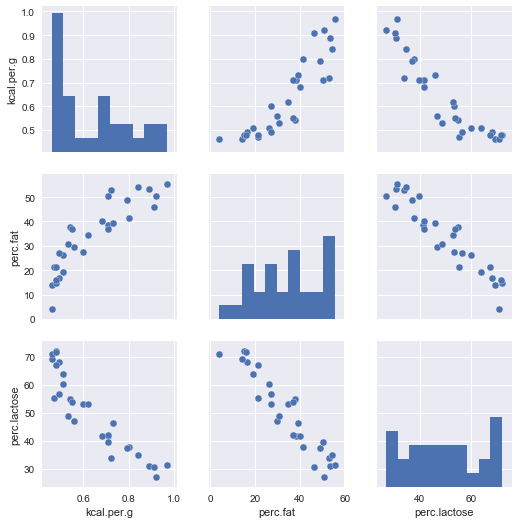

In [44]:
data = d[["kcal.per.g", "perc.fat", "perc.lactose"]]
sns.pairplot(data);

### 5.39

In [45]:
d.corr()["perc.fat"]["perc.lactose"]

-0.9416373456839282

### 5.40

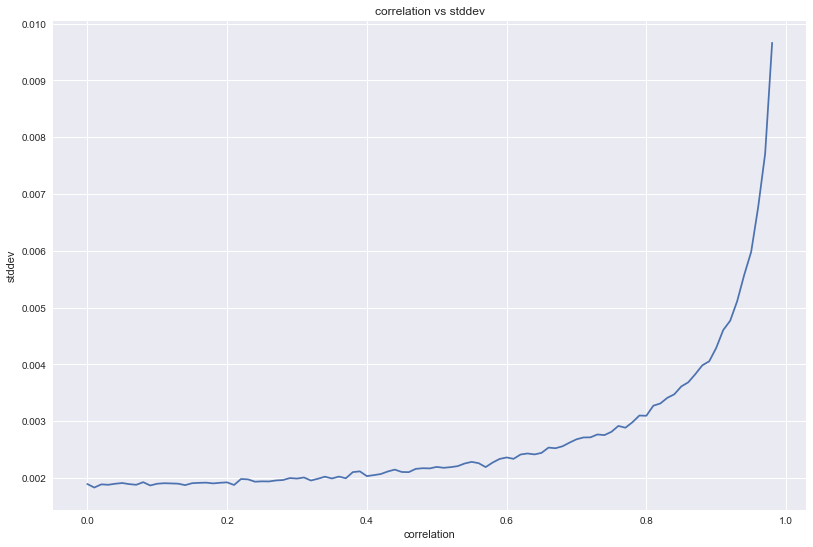

In [46]:
d = pd.read_csv('Data/milk.csv', sep=';')

def sim_coll(r=0.9):
    d['x'] = stats.norm.rvs(size=len(d), 
                            loc = r * d['perc.fat'],
                            scale = np.sqrt((1 - r**2) * d['perc.fat'].var()))
    m = smf.OLS(d['kcal.per.g'], d[["perc.fat", "x"]]).fit()
    cov = m.cov_params()
    return (np.diag(cov)[1])**0.5
    
def rep_sim_coll(r=0.9, n=100):
    stddev = [sim_coll(r) for _ in range(n)]
    return np.mean(stddev)

r_seq = np.arange(0, 0.99, 0.01)
stddev = [rep_sim_coll(r=z, n=100) for z in r_seq]


f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)

ax.plot(r_seq, stddev)
ax.set_title("correlation vs stddev")
ax.set_xlabel("correlation")
ax.set_ylabel("stddev");

### 5.41

In [47]:
# Number of Plants
N = 100

# simulate initial heights
h0 = stats.norm.rvs(10, 2, N)

# assign treatments and simulate fungus and growth
treatment = np.repeat([0, 1], [N/2]*2)
fungus = stats.binom.rvs(1, 0.5 - treatment*0.4)
h1 = h0 + stats.norm.rvs(5-3*fungus)

# compose a clean data frame
d = pd.DataFrame({"h0": h0,
                  "h1": h1,
                  "treatment": treatment,
                  "fungus": fungus})

### 5.42

In [48]:
with pm.Model() as m5_13:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    bf = pm.Normal("bf", mu=0, sd=10)
    bt = pm.Normal("bt", mu=0, sd=10)
    bh = pm.Normal("bh", mu=0, sd=10)
    a = pm.Normal("a", mu=0, sd=100)
    mu = pm.Deterministic("mu", a + bh*d["h0"] + bt*d["treatment"] + bf*d["fungus"])
    h1 = pm.Normal("h1", mu=mu, sd=sigma, observed=d["h1"])
    trace_5_13 = pm.sample(int(1e4), tune=1000)
    
pm.summary(trace_5_13, varnames=["a", "bh", "bt", "bf", "sigma"], alpha=0.11)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bh, bt, bf, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:51<00:00, 429.58draws/s]


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,5.908683,0.523792,0.005705,5.061687,6.730268,8394.383381,1.000007
bh,0.911278,0.049430,0.000531,0.828379,0.986609,8957.583461,0.999996
bt,-0.068347,0.211057,0.001732,-0.404170,0.264386,13874.282447,1.000065
bf,-2.996531,0.234303,0.001792,-3.362813,-2.614051,13133.210812,1.000048
sigma,0.993802,0.073581,0.000617,0.877250,1.109567,15445.834458,0.999992


### 5.43

In [49]:
with pm.Model() as m5_14:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    bt = pm.Normal("bt", mu=0, sd=10)
    bh = pm.Normal("bh", mu=0, sd=10)
    a = pm.Normal("a", mu=0, sd=100)
    mu = pm.Deterministic("mu", a + bh*d["h0"] + bt*d["treatment"])
    h1 = pm.Normal("h1", mu=mu, sd=sigma, observed=d["h1"])
    trace_5_14 = pm.sample(int(1e4), tune=1000)
    
pm.summary(trace_5_14, varnames=["a", "bh", "bt", "sigma"], alpha=0.11)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bh, bt, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:54<00:00, 400.54draws/s]


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,4.287982,0.846786,0.010417,2.968963,5.682410,7359.300380,1.000102
bh,0.947367,0.082127,0.000968,0.820833,1.082282,7853.198778,1.000046
bt,0.789326,0.332478,0.002979,0.250859,1.308786,12164.448110,1.000238
sigma,1.644890,0.119001,0.001180,1.452872,1.827215,13682.872596,0.999951


## Categorical Variables

### 5.44

In [50]:
d = pd.read_csv('Data/Howell1.csv', sep=';')
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


### 5.45

In [51]:
with pm.Model() as m5_15:
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    bm = pm.Normal("bm", mu=0, sd=10)
    a = pm.Normal("a", mu=178, sd=100)
    mu = pm.Deterministic("mu", a + bm*d["male"])
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d["height"])
    trace_5_15 = pm.sample(int(1e4), tune=1000)
    
pm.summary(trace_5_15, varnames=["a", "bm", "sigma"], alpha=0.11)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bm, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:18<00:00, 1171.36draws/s]


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,134.829908,1.593063,0.014435,132.274991,137.340568,13035.069811,1.000174
bm,7.269767,2.299526,0.020206,3.325944,10.697432,12773.564684,1.000032
sigma,27.422046,0.833530,0.006465,26.086413,28.726241,15206.298709,0.999952


### 5.46

In [52]:
mu_male = trace_5_15["a"] + trace_5_15["bm"]
pm.hpd(mu_male, alpha=0.11)

array([139.35518977, 144.72170868])

### 5.47

In [53]:
with pm.Model() as m5_15b:
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    am = pm.Normal("am", mu=178, sd=100)
    af = pm.Normal("af", mu=178, sd=100)
    mu = pm.Deterministic("mu", af*(1-d["male"]) + am*d["male"])
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d["height"])
    trace_5_15b = pm.sample(int(1e4), tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [af, am, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:13<00:00, 1622.83draws/s]


### 5.48

In [54]:
d = pd.read_csv('Data/milk.csv', sep=';')
d["clade"].drop_duplicates()

0        Strepsirrhine
5     New World Monkey
14    Old World Monkey
20                 Ape
Name: clade, dtype: object

### 5.49

In [55]:
d["clade_NWM"] = np.where(d["clade"] == "New World Monkey", 1, 0)

### 5.50

In [56]:
d["clade_OWM"] = np.where(d["clade"] == "Old World Monkey", 1, 0)
d["clade_S"] = np.where(d["clade"] == "Strepsirrhine", 1, 0)

### 5.51

In [57]:
with pm.Model() as m5_16:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    b_S = pm.Normal("b_S", mu=0, sd=1)
    b_OWM = pm.Normal("b_OWM", mu=0, sd=1)
    b_NWM = pm.Normal("b_NWM", mu=0, sd=1)
    a = pm.Normal("a", mu=0.6, sd=10)
    mu = pm.Deterministic("mu", a + b_NWM*d["clade_NWM"] + b_OWM*d["clade_OWM"] + b_S*d["clade_S"])
    kcal_per_g = pm.Normal("kcal_per_g", mu=mu, sd=sigma, observed=d["kcal.per.g"])
    trace_5_16 = pm.sample(int(1e4), tune=1000)
    
pm.summary(trace_5_16, varnames=["a", "b_NWM", "b_OWM", "b_S", "sigma"], alpha=0.11)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, b_NWM, b_OWM, b_S, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:24<00:00, 888.01draws/s] 


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,0.546497,0.043847,0.000463,0.475447,0.614842,9389.411876,0.999954
b_NWM,0.167543,0.062390,0.000629,0.070536,0.267578,11038.490628,0.999984
b_OWM,0.241309,0.068632,0.000706,0.127867,0.345706,11201.382371,1.000118
b_S,-0.038230,0.073389,0.000701,-0.154393,0.077574,11680.616422,1.000141
sigma,0.129920,0.019619,0.000163,0.098975,0.158819,13669.913912,0.999950


### 5.52

In [58]:
mu_ape = trace_5_16["a"]
mu_NWM = trace_5_16["a"] + trace_5_16["b_NWM"]
mu_OWM = trace_5_16["a"] + trace_5_16["b_OWM"]
mu_S = trace_5_16["a"] + trace_5_16["b_S"]

mu = np.stack([mu_ape, mu_NWM, mu_OWM, mu_S]).T
mu_mean = np.mean(mu, axis=0)
mu_std = np.std(mu, axis=0)
mu_hpd = pm.hpd(mu, alpha=0.11)

pd.DataFrame({"mean": mu_mean,
              "std": mu_std,
              "hpd_5.5": mu_hpd[:, 0],
              "hpd_94.5": mu_hpd[:, 1]},
             index=["mu_ape", "mu_NWM", "mu_OWM", "mu_S"])

,mean,std,hpd_5.5,hpd_94.5
mu_ape,0.546497,0.043847,0.475447,0.614842
mu_NWM,0.714040,0.043648,0.646046,0.783672
mu_OWM,0.787806,0.053567,0.703445,0.872936
mu_S,0.508266,0.058753,0.414565,0.600043


### 5.53

In [59]:
diff_NWM_OWM = mu_NWM - mu_OWM
np.percentile(diff_NWM_OWM, [2.5, 50, 97.5])

array([-0.20982162, -0.07343667,  0.06100252])

### 5.54

In [60]:
d["clade_id"] = pd.Categorical(d["clade"]).codes

### 5.55

In [61]:
with pm.Model() as m5_16_alt:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    a = pm.Normal("a", mu=0.6, sd=10, shape=len(d["clade_id"].unique()))
    kcal_per_g = pm.Normal("kcal_per_g", mu=a[d["clade_id"].values], sd=sigma, observed=d["kcal.per.g"])
    trace_5_16_alt = pm.sample(int(1e4), tune=1000)
    
pm.summary(trace_5_16_alt, varnames=["a", "sigma"], alpha=0.11)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:20<00:00, 1064.96draws/s]


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a__0,0.545634,0.043412,0.000267,0.474677,0.612647,24135.622373,0.999997
a__1,0.714399,0.043913,0.000255,0.645051,0.783823,22835.892461,0.999988
a__2,0.788388,0.054289,0.000338,0.701133,0.872855,23820.515955,0.999967
a__3,0.507661,0.059117,0.000326,0.410300,0.598852,25393.048661,1.000018
sigma,0.129972,0.019649,0.000156,0.099555,0.158662,13448.947386,0.999951
